In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler

In [33]:
#data_00="/home/mustapha/Downloads/Predictive-Modeling-of-Ionic-Conductivity-in-Garnet-Type-Solid-Electrolytes-main/Data/data_65.csv"
file_path = "/home/mustapha/Downloads/data_augmented.xlsx"
file_path1 = "/home/mustapha/Downloads/Predictive-Modeling-of-Ionic-Conductivity-in-Garnet-Type-Solid-Electrolytes-main/Data/data_augmented.xlsx"



#df0 = pd.read_excel(file_path1)
df = pd.read_excel(file_path)
df1 = df.iloc[:176]
df2 = df.iloc[176:]

In [34]:
def transform_to_material_formula(row):
    # Extract the values from each column
    a = row['Li stoichiometry']
    b = row['La stoichiometry']
    c = row['Zr stoichiometry']
    x = row['Li site dopant stoichiometry']
    y = row['La site dopant stoichiometry']
    z = row['Zr site dopant stoichiometry']
    M = row['li_dopant']
    N = row['la_dopant']
    K = row['zr_dopant']



    formula = ''


    if a > 0:
        formula += f'Li{a:.2f}'

    # Add M if x > 0
    if x > 0:
        formula += f'{M}{x:.2f}'

    # Add La with its stoichiometry
    if b > 0:
        formula += f'La{b:.2f}'

    # Add N if y > 0
    if y > 0:
        formula += f'{N}{y:.2f}'

    # Add Zr with its stoichiometry
    if c > 0:
        formula += f'Zr{c:.2f}'

    # Add K if z > 0
    if z > 0:
        formula += f'{K}{z:.2f}'
        
    formula += f'O12'
   
    return formula



# Assuming you have a DataFrame named 'df' and want to create a new column 'MaterialFormula'
df['MaterialFormula'] = df.apply(transform_to_material_formula, axis=1)


In [35]:
#def interpolate_relative_density(df):
#    # Sort by 'MaterialFormula' and 'log_cond' to ensure correct interpolation
#    df = df.sort_values(by=['MaterialFormula', 'Ionic conductivity']).reset_index(drop=True)

#    # Interpolate 'Relative density' within each 'MaterialFormula' group
#    interpolated = df.groupby('MaterialFormula')['Relative density'].apply(lambda group: group.interpolate(method='linear'))

#    # Ensure the index matches the original DataFrame's index
#    df['Relative density'] = interpolated.reset_index(level=0, drop=True)

#   # Fill remaining missing values with forward fill and backward fill
#    df['Relative density'] = df['Relative density'].ffill().bfill()

#   return df



#df = interpolate_relative_density(df)
#df.info()


In [36]:
import pandas as pd
from sklearn.impute import KNNImputer

def knn_impute_relative_density(df, n_neighbors=5):
    # Check if 'log_cond' has any missing values
    if df['log_cond'].isna().all():
        # If 'log_cond' is entirely NaN, skip KNN and just ffill/bfill
        df['Relative density'] = df['Relative density'].ffill().bfill()
    else:
        # Select only the relevant columns for KNN imputation
        impute_df = df[['log_cond', 'Relative density']]

        # Initialize the KNNImputer
        imputer = KNNImputer(n_neighbors=n_neighbors)

        # Apply KNN Imputer
        imputed_values = imputer.fit_transform(impute_df)

        # Replace 'Relative density' column with imputed values
        df['Relative density'] = imputed_values[:, -1]  # Use the last column, which is 'Relative density'

        # Fill remaining missing values with forward fill and backward fill
        df['Relative density'] = df['Relative density'].ffill().bfill()

    return df

# Example usage
df = knn_impute_relative_density(df)
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 362 entries, 0 to 361
Data columns (total 45 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   source                            361 non-null    object 
 1   Publication year                  359 non-null    float64
 2   T of the conductivity C           349 non-null    float64
 3   Li stoichiometry                  362 non-null    float64
 4   La stoichiometry                  362 non-null    float64
 5   Zr stoichiometry                  362 non-null    float64
 6   Li site dopant stoichiometry      362 non-null    float64
 7   La site dopant stoichiometry      362 non-null    float64
 8   Zr site dopant stoichiometry      362 non-null    float64
 9   Relative density                  362 non-null    float64
 10  Ionic conductivity                359 non-null    float64
 11  log_cond                          359 non-null    float64
 12  Quality 

In [37]:
materials_to_remove = ['Li6.40Al0.20La3.00Zr2.00O12', 'Li6.25Al0.25La3.00Zr2.00O12']
#df = df[~df['MaterialFormula'].isin(materials_to_remove)]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 362 entries, 0 to 361
Data columns (total 45 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   source                            361 non-null    object 
 1   Publication year                  359 non-null    float64
 2   T of the conductivity C           349 non-null    float64
 3   Li stoichiometry                  362 non-null    float64
 4   La stoichiometry                  362 non-null    float64
 5   Zr stoichiometry                  362 non-null    float64
 6   Li site dopant stoichiometry      362 non-null    float64
 7   La site dopant stoichiometry      362 non-null    float64
 8   Zr site dopant stoichiometry      362 non-null    float64
 9   Relative density                  362 non-null    float64
 10  Ionic conductivity                359 non-null    float64
 11  log_cond                          359 non-null    float64
 12  Quality 

In [38]:
import numpy as np
import pandas as pd
from scipy.stats import linregress
import matplotlib.pyplot as plt
import seaborn as sns

def check_monotonicity_with_deviation_removal(df, max_allowed_deviations, deviation_threshold):
    filtered_data = []
    non_increasing_materials = []

    grouped = df.groupby('MaterialFormula')

    for material, group in grouped:
        group_sorted = group.sort_values('Relative density')
        densities = group_sorted['Relative density'].values
        conductivities = group_sorted['log_cond'].values

        # Check for NaN or infinite values and remove them
        if np.any(np.isnan(conductivities)):
            print(f"Skipping material {material} due to NaN values.")
            continue

        if np.any(np.isinf(densities)) or np.any(np.isinf(conductivities)):
            print(f"Skipping material {material} due to infinite values.")
            continue

        # Handle materials with only one unique density value
        if len(np.unique(densities)) < 2:
            print(f"Including material {material} with a single unique 'Relative density' value.")
            filtered_data.append(group_sorted)
            continue

        # Fit a linear model to capture the average increasing trend
        slope, intercept, _, _, _ = linregress(densities, conductivities)

        # Check if the slope is positive
        if slope <= 0:
            non_increasing_materials.append(material)
            continue

        expected_trend = intercept + slope * densities
        deviations = conductivities - expected_trend
        significant_deviations = np.abs(deviations) > deviation_threshold

        # If the number of significant deviations is within the allowed limit, filter them out
        if significant_deviations.sum() <= max_allowed_deviations:
            group_filtered = group_sorted[~significant_deviations]
        else:
            # Otherwise, skip the entire material
            continue

        filtered_data.append(group_filtered)

    # Combine filtered data into a single DataFrame
    filtered_df = pd.concat(filtered_data)

    # Plot non-increasing materials
    sns.set(style="whitegrid")
    for material in non_increasing_materials:
        group = df[df['MaterialFormula'] == material]
        plt.figure(figsize=(6, 4))
        sns.lineplot(
            x='Relative density',
            y='log_cond',
            data=group,
            marker='o',
            label=material,
        )
        plt.title(f'Non-Increasing Trend for {material}')
        plt.xlabel('Relative density')
        plt.ylabel('log_cond')
        plt.legend()
        plt.show()

    # Remove non-increasing materials from the dataset
    filtered_df = filtered_df[~filtered_df['MaterialFormula'].isin(non_increasing_materials)]

    return filtered_df




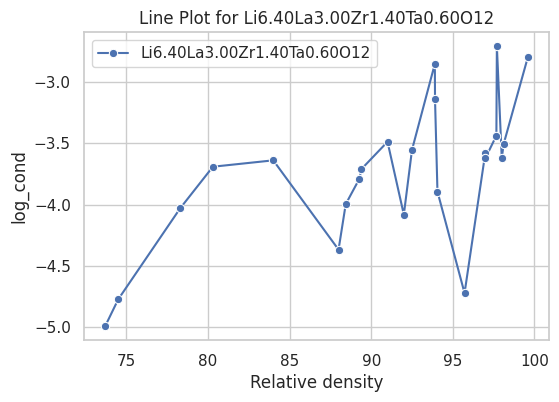

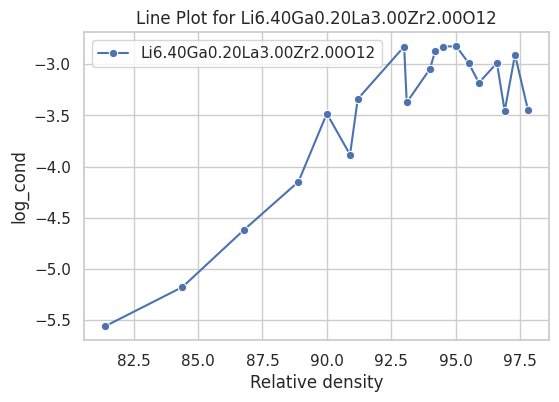

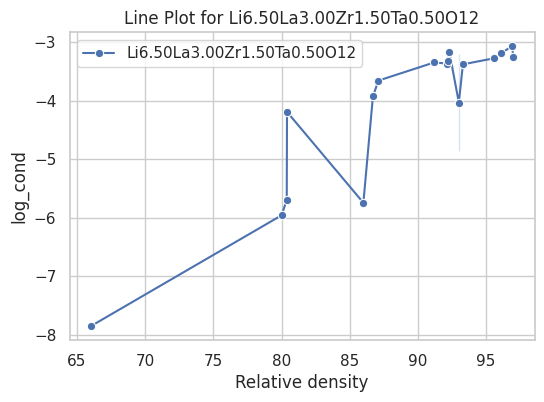

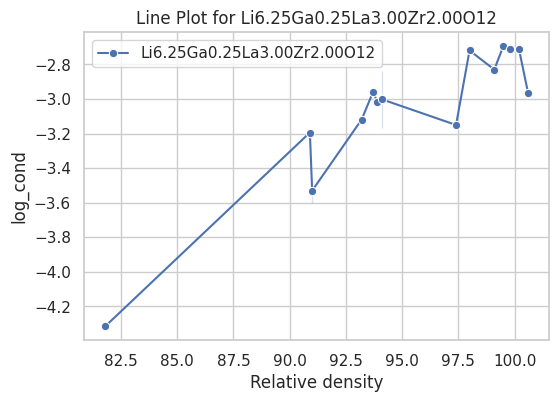

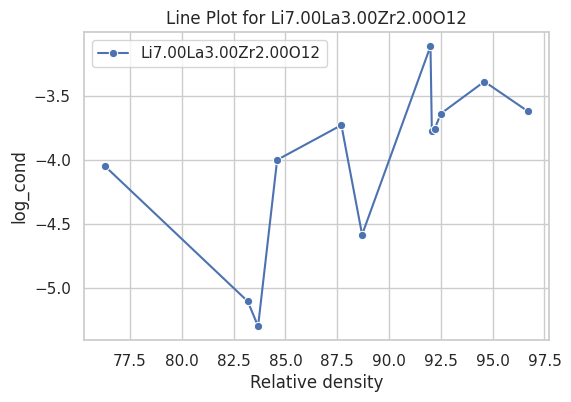

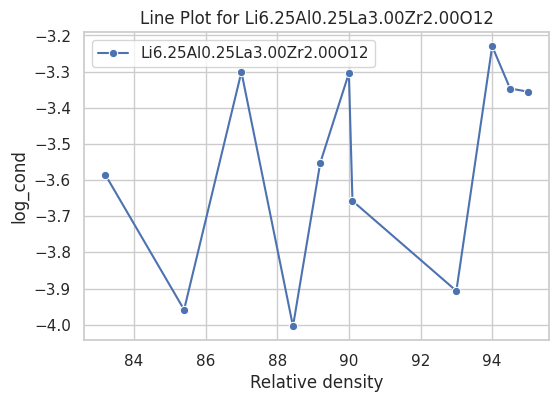

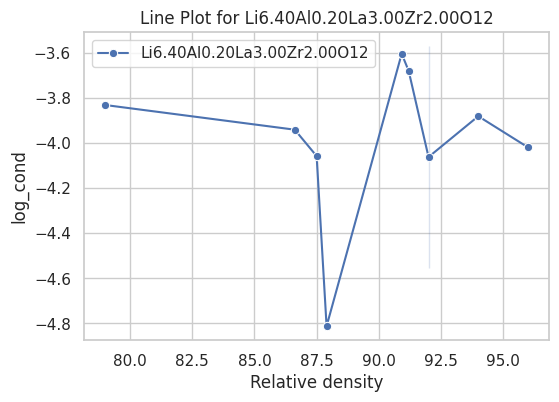

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_top_materials(df, num_materials):

    # Counting the occurrences of each material formula
    material_counts = df['MaterialFormula'].value_counts()

    # Getting the top N most repeated materials
    top_materials = material_counts.nlargest(num_materials)

    sns.set(style="whitegrid")

    # Looping through the top materials and plotting their data
    for selected_material in top_materials.index:
        selected_material_data = df[df['MaterialFormula'] == selected_material]
        plt.figure(figsize=(6, 4))
        sns.lineplot(
            x='Relative density',
            y='log_cond',
            data=selected_material_data,
            marker='o',
            label=selected_material,
        )
        plt.title(f'Line Plot for {selected_material}')
        plt.xlabel('Relative density')
        plt.ylabel('log_cond')
        plt.legend()
        plt.show()


plot_top_materials(df, 7)

Including material Li5.00La3.00Ta2.00O12 with a single unique 'Relative density' value.
Including material Li5.40La2.80Na0.20Nb2.00O12 with a single unique 'Relative density' value.
Including material Li5.50La3.00Zr0.50Ta1.50O12 with a single unique 'Relative density' value.
Including material Li5.80Ga0.40La3.00Zr2.00O12 with a single unique 'Relative density' value.
Including material Li5.80La2.60Na0.40Nb2.00O12 with a single unique 'Relative density' value.
Including material Li5.90Al0.20La3.00Zr1.75W0.25O12 with a single unique 'Relative density' value.
Including material Li5.90Ga0.30La3.00Zr1.80Nb0.20O12 with a single unique 'Relative density' value.
Including material Li5.90La3.00Zr1.45W0.55O12 with a single unique 'Relative density' value.
Including material Li5.95Al0.35La3.00Zr2.00O12 with a single unique 'Relative density' value.
Including material Li5.95Ga0.35La3.00Zr2.00O12 with a single unique 'Relative density' value.
Including material Li6.00La3.00Zr1.00Bi1.00O12 with a si

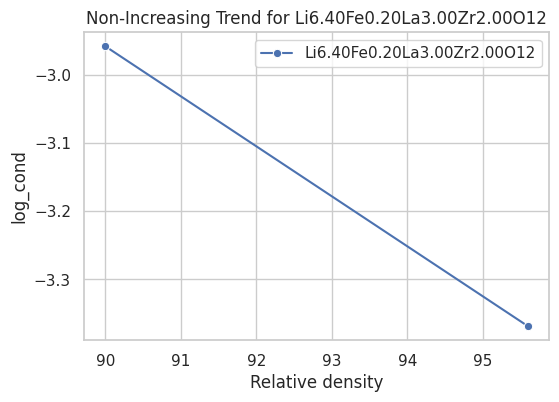

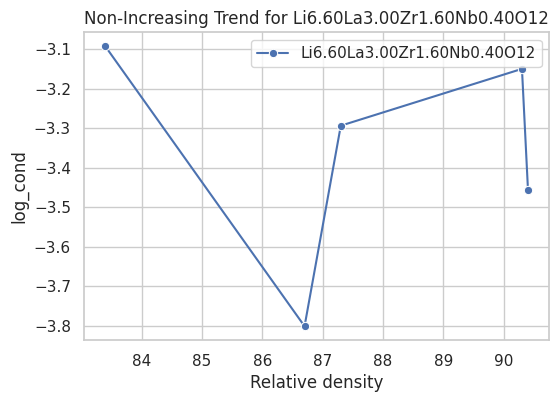

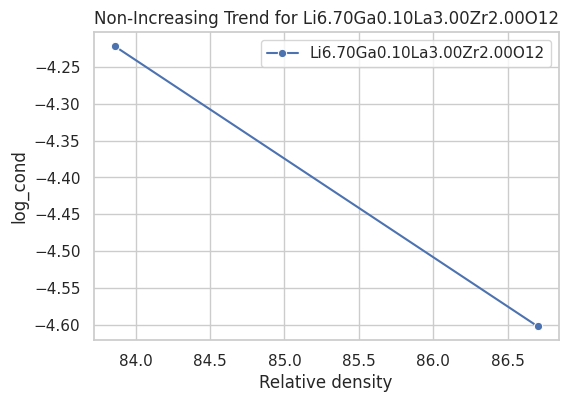

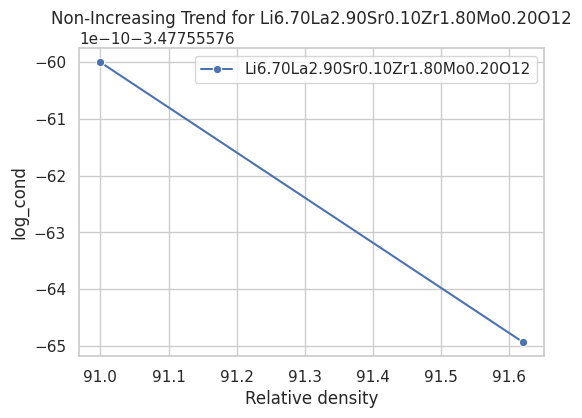

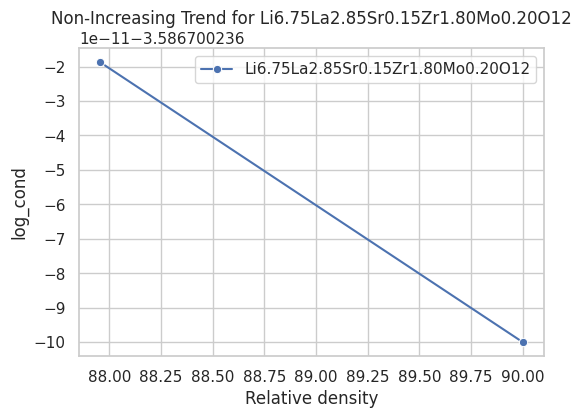

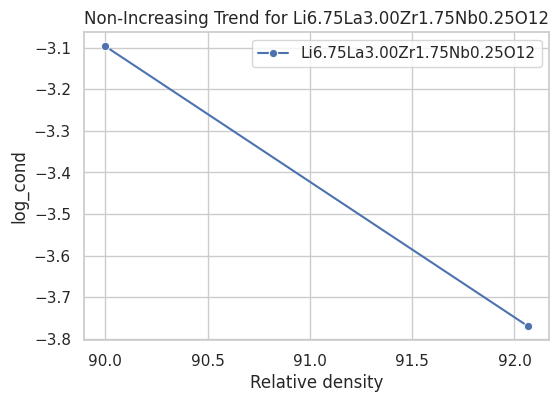

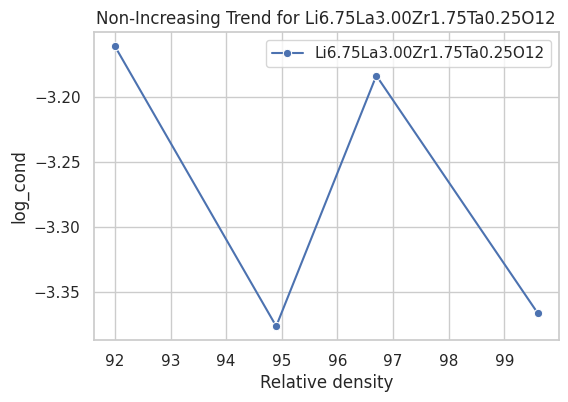

In [40]:

df = check_monotonicity_with_deviation_removal(df, max_allowed_deviations=10, deviation_threshold=.2)

In [41]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_electric_neutrality(df, tolerance):
    # Ensure DataFrame has necessary columns
    required_columns = [
        'Li stoichiometry', 'La stoichiometry', 'Zr stoichiometry',
        'Li site dopant stoichiometry', 'Li site dopant ion charge',
        'La site dopant stoichiometry', 'La site dopant ion charge',
        'Zr site dopant stoichiometry', 'Zr site dopant ion charge'
    ]
    
    for col in required_columns:
        if col not in df.columns:
            raise ValueError(f"Column '{col}' is missing from the DataFrame")

    # Calculate the total charge for each row
    df['Total Charge'] = (
        df['Li stoichiometry'] * 1 +  # Li has a charge of +1
        df['La stoichiometry'] * 3 +  # La has a charge of +3
        df['Zr stoichiometry'] * 4 +  # Zr has a charge of +4
        df['Li site dopant stoichiometry'] * df['Li site dopant ion charge'] +  # Li site dopant charge
        df['La site dopant stoichiometry'] * df['La site dopant ion charge'] +  # La site dopant charge
        df['Zr site dopant stoichiometry'] * df['Zr site dopant ion charge']  # Zr site dopant charge
    )
    
    # Subtract 24 from the total charge to check neutrality
    df['Charge Difference'] = df['Total Charge'] - 24

    # Identify rows that do not satisfy neutrality within the specified tolerance
    non_neutrality_indexes = df[df['Charge Difference'].abs() > tolerance].index

    df_filtered = df.drop(non_neutrality_indexes)

    # Plotting the charge difference
    plt.figure(figsize=(10, 6))
    plt.scatter(df.index, df['Charge Difference'], alpha=0.7, edgecolors='w', s=100)
    plt.axhline(y=0, color='r', linestyle='--', label='Neutrality Line (Charge = 24)')
    plt.axhline(y=tolerance, color='g', linestyle='--', label=f'Neutrality Tolerance ±{tolerance}')
    plt.axhline(y=-tolerance, color='g', linestyle='--')
    plt.xlabel('Index')
    plt.ylabel('Charge Difference (Total Charge - 24)')
    plt.title('Electric Neutrality of the Material')
    plt.legend()
    plt.grid(True)
    plt.show()

    return df_filtered, non_neutrality_indexes

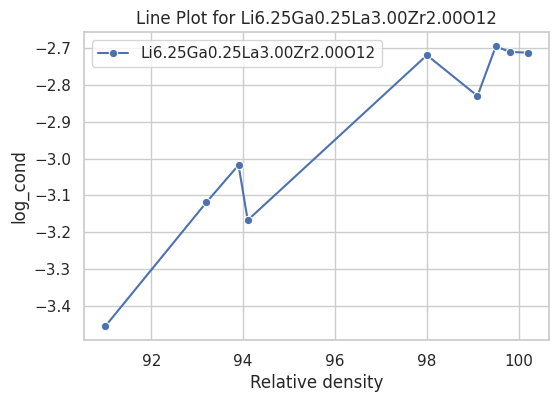

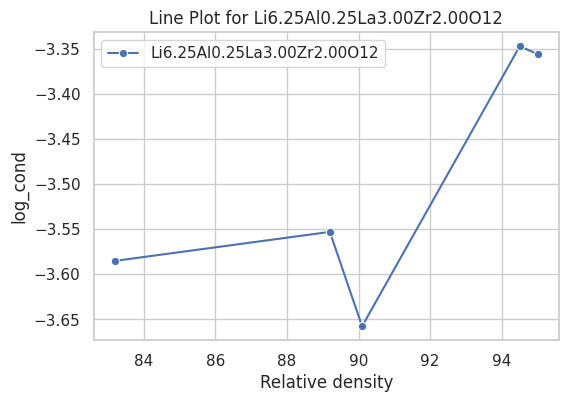

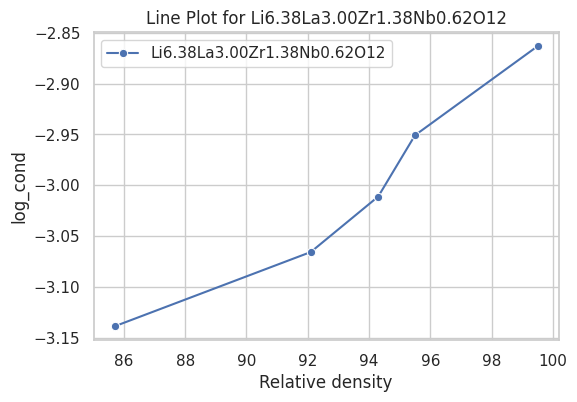

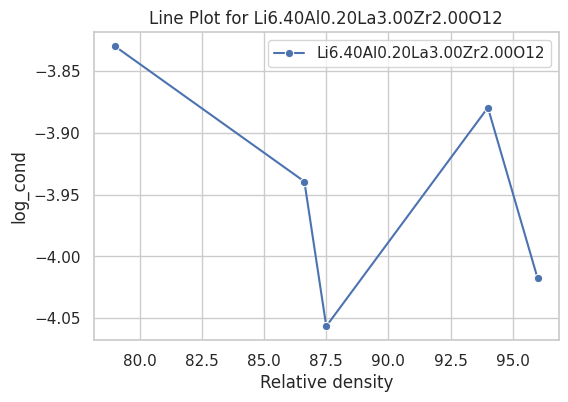

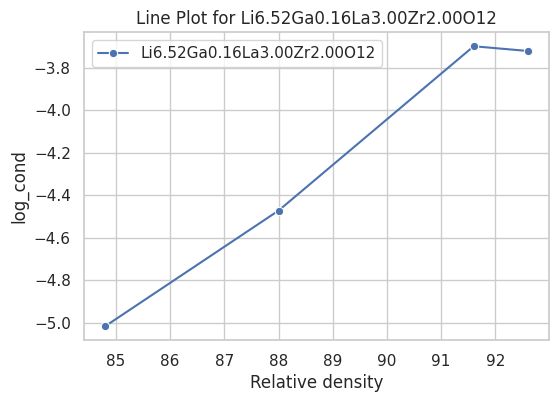

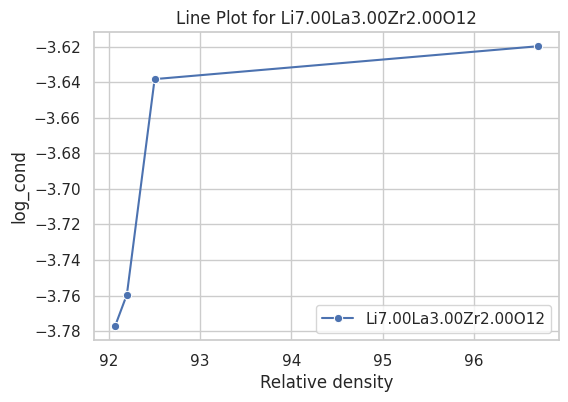

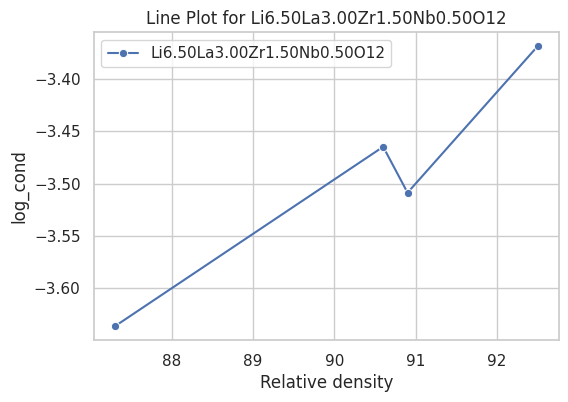

In [42]:
plot_top_materials(df, 7)

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 236 entries, 51 to 131
Data columns (total 45 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   source                            236 non-null    object 
 1   Publication year                  233 non-null    float64
 2   T of the conductivity C           225 non-null    float64
 3   Li stoichiometry                  236 non-null    float64
 4   La stoichiometry                  236 non-null    float64
 5   Zr stoichiometry                  236 non-null    float64
 6   Li site dopant stoichiometry      236 non-null    float64
 7   La site dopant stoichiometry      236 non-null    float64
 8   Zr site dopant stoichiometry      236 non-null    float64
 9   Relative density                  236 non-null    float64
 10  Ionic conductivity                236 non-null    float64
 11  log_cond                          236 non-null    float64
 12  Quality of i

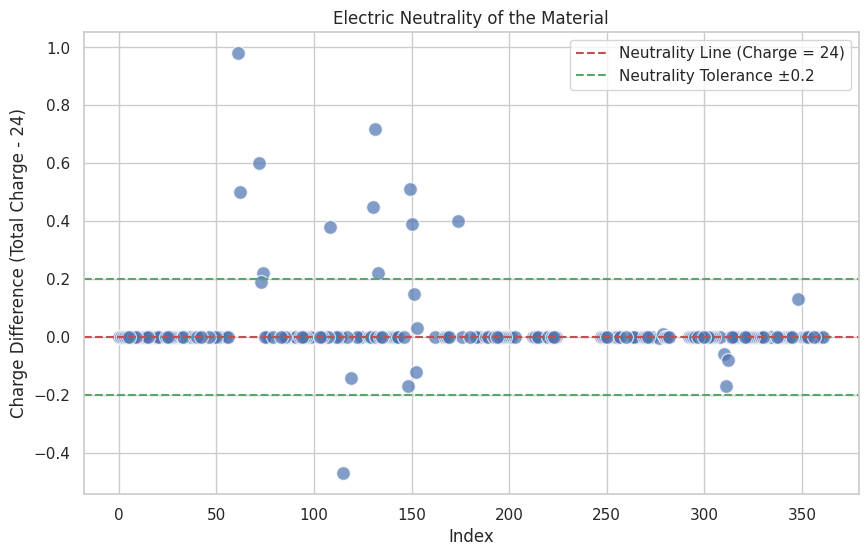

<class 'pandas.core.frame.DataFrame'>
Index: 224 entries, 51 to 5
Data columns (total 47 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   source                            224 non-null    object 
 1   Publication year                  222 non-null    float64
 2   T of the conductivity C           214 non-null    float64
 3   Li stoichiometry                  224 non-null    float64
 4   La stoichiometry                  224 non-null    float64
 5   Zr stoichiometry                  224 non-null    float64
 6   Li site dopant stoichiometry      224 non-null    float64
 7   La site dopant stoichiometry      224 non-null    float64
 8   Zr site dopant stoichiometry      224 non-null    float64
 9   Relative density                  224 non-null    float64
 10  Ionic conductivity                224 non-null    float64
 11  log_cond                          224 non-null    float64
 12  Quality of ion

In [44]:
df, non_neutrality_indexes = plot_electric_neutrality(df, 0.2)

# Inspect the filtered DataFrame and the indices of non-neutral rows
df.info()

In [45]:
X=df
X = X.drop(['log_cond'],axis=1)
X = X.drop(['Publication year','Quality of ionic conductivity','source','Doping strategy'], axis=1)
X = X.drop(['MaterialFormula'],axis=1)
X = X.drop(['li_dopant','la_dopant','zr_dopant'], axis=1)
X = X.drop(['Total Charge','Charge Difference'], axis=1)

In [46]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 224 entries, 51 to 5
Data columns (total 36 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   T of the conductivity C           214 non-null    float64
 1   Li stoichiometry                  224 non-null    float64
 2   La stoichiometry                  224 non-null    float64
 3   Zr stoichiometry                  224 non-null    float64
 4   Li site dopant stoichiometry      224 non-null    float64
 5   La site dopant stoichiometry      224 non-null    float64
 6   Zr site dopant stoichiometry      224 non-null    float64
 7   Relative density                  224 non-null    float64
 8   Ionic conductivity                224 non-null    float64
 9   Li site dopant crystal rad.       224 non-null    int64  
 10  Li site dopant ion charge         224 non-null    int64  
 11  Li site dopant electroneg.        224 non-null    float64
 12  Li site dopant

In [47]:
from sklearn.impute import KNNImputer
knn_imputer = KNNImputer(n_neighbors=3)
# Fit and transform the data to impute the missing values
X_knn = knn_imputer.fit_transform(X)

# Convert the imputed NumPy array back to a DataFrame and specify column names
X_knn = pd.DataFrame(data=X_knn, columns=X.columns)

# Assuming you already have 'Ionic conductivity' in the DataFrame
Y = X_knn['Ionic conductivity']

# Drop the 'Ionic conductivity' column from X
X_knn = X_knn.drop('Ionic conductivity', axis=1)

In [48]:
X_knn.columns


Index(['T of the conductivity C', 'Li stoichiometry', 'La stoichiometry',
       'Zr stoichiometry', 'Li site dopant stoichiometry',
       'La site dopant stoichiometry', 'Zr site dopant stoichiometry',
       'Relative density', 'Li site dopant crystal rad.',
       'Li site dopant ion charge', 'Li site dopant electroneg.',
       'Li site dopant molar mass', 'Li site dopant atomic number',
       'Li site dopant e_ionisation', 'Li site dopant electron affinity',
       'Li site dopant atomic radius', 'Li site dopant ionic radius',
       'La site dopant crystal rad.', 'La site dopant ion charge',
       'La site dopant electroneg.', 'La site dopant molar mass',
       'La site dopant atomic number', 'La site dopant e_ionisation',
       'La site dopant electron affinity', 'La site dopant atomic radius',
       'La site dopant ionic radius', 'Zr site dopant crystal rad.',
       'Zr site dopant ion charge', 'Zr site dopant electroneg.',
       'Zr site dopant molar mass', 'Zr site do

In [65]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import pandas as pd

# Define a list of regression models to test
models = [
    HistGradientBoostingRegressor(),
    LinearRegression(),
    Ridge(),
    RandomForestRegressor(),
    GradientBoostingRegressor(),
    KNeighborsRegressor(),
    XGBRegressor(),
    LGBMRegressor(),
    CatBoostRegressor(),
    RandomForestRegressor()
]

# Define the different test split sizes
test_splits = [0.20, 0.25, 0.30]

# Preprocessing steps
# Define numerical and categorical features
numeric_features = X_knn.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_knn.select_dtypes(include=['object', 'category']).columns

# Preprocessing for numerical data
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing for numeric and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Initialize an empty list to store the results
results = []

# Iterate over the models and evaluate each one for different test split sizes
for model in models:
    for test_size in test_splits:
        # Splitting the data into training and testing sets
        X_train, X_test, Y_train, Y_test = train_test_split(X_knn, Y, test_size=test_size, random_state=42)

        # Create a pipeline that includes preprocessing and the model
        pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                   ('model', model)])

        # Fit the model and make predictions
        pipeline.fit(X_train, Y_train)
        Y_test_pred = pipeline.predict(X_test)

        # Calculate metrics
        mse = mean_squared_error(Y_test, Y_test_pred)
        r2 = r2_score(Y_test, Y_test_pred)

        # Record the results
        results.append({
            "Model": type(model).__name__,
            "Test Split Size": test_size,
            "R-squared (R2)": r2,
            "Mean Squared Error (MSE)": mse
        })

# Convert results to a DataFrame for easy viewing
results_df = pd.DataFrame(results)



results_df.sort_values(by='R-squared (R2)', ascending=False, inplace=True)

# Resetting the indexes to start from 1
results_df.reset_index(drop=True, inplace=True)
results_df

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

,Model,Test Split Size,R-squared (R2),Mean Squared Error (MSE)
0,CatBoostRegressor,0.20,0.772512,4.934430e-08
1,LGBMRegressor,0.20,0.757077,5.269224e-08
2,HistGradientBoostingRegressor,0.20,0.746647,5.495466e-08
3,KNeighborsRegressor,0.20,0.698764,6.534089e-08
4,GradientBoostingRegressor,0.20,0.668482,7.190930e-08
5,CatBoostRegressor,0.30,0.663442,7.122086e-08
6,GradientBoostingRegressor,0.30,0.647470,7.460081e-08
7,HistGradientBoostingRegressor,0.30,0.588404,8.710008e-08
8,CatBoostRegressor,0.25,0.587513,7.822319e-08
9,LGBMRegressor,0.30,0.575575,8.981498e-08


In [66]:
import itertools
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from sklearn.metrics import r2_score
import pandas as pd

# Define the groups
GROUP1 = [
    ['Li stoichiometry', 'La stoichiometry', 'Zr stoichiometry','Relative density'],
    ['Li site dopant stoichiometry', 'La site dopant stoichiometry', 'Zr site dopant stoichiometry','Relative density'],
    ['Li stoichiometry', 'La stoichiometry', 'Zr stoichiometry'],
    ['Li site dopant stoichiometry', 'La site dopant stoichiometry', 'Zr site dopant stoichiometry']
]

GROUP2 = [
    ['Li site dopant ionic radius', 'La site dopant ionic radius', 'Zr site dopant ionic radius'],
    ['Li site dopant atomic radius', 'La site dopant atomic radius', 'Zr site dopant atomic radius pm'],
    ['Li site dopant electron affinity', 'La site dopant electron affinity', 'Zr site dopant electron affinity'],
    ['Li site dopant e_ionisation', 'La site dopant e_ionisation', 'Zr site dopant e_ionisation'],
    ['Li site dopant atomic number', 'La site dopant atomic number', 'Zr site dopant atomic number'],
    ['Li site dopant molar mass', 'La site dopant molar mass', 'Zr site dopant molar mass'],
    ['Li site dopant electroneg.', 'La site dopant electroneg.', 'Zr site dopant electroneg.'],
    ['Li site dopant ion charge', 'La site dopant ion charge', 'Zr site dopant ion charge'],
    ['Li site dopant crystal rad.', 'La site dopant crystal rad.', 'Zr site dopant crystal rad.']
]

# Initialize a list to store the results
results = []

# Iterate over all combinations of one or more lines from GROUP1
for group1_combination in itertools.combinations(GROUP1, r=1):
    
    # Iterate over all combinations of one or more lines from GROUP2
    for r in range(1, len(GROUP2) + 1):
        for group2_combination in itertools.combinations(GROUP2, r=r):
            
            # Combine the selected features from both groups
            selected_features = [cols for sublist in group1_combination for cols in sublist] + \
                                [cols for sublist in group2_combination for cols in sublist]
            
            # Select only the features for this combination
            X_temp = X_knn[selected_features]
            
            # Split the data
            X_train, X_test, Y_train, Y_test = train_test_split(X_temp, Y, test_size=0.2, random_state=42)
            
            # Train the model using CatBoostRegressor
            model = HistGradientBoostingRegressor()
            model.fit(X_train, Y_train)
            Y_test_pred = model.predict(X_test)
            
            # Evaluate the model
            r2 = r2_score(Y_test, Y_test_pred)
            
            # Store the result
            results.append({
                'Selected_features': selected_features,
                'R-squared (R2)': r2
            })

# Convert results to a DataFrame for easy viewing
results_df = pd.DataFrame(results)

# Find the best result based on the R² score
best_result = results_df.sort_values(by='R-squared (R2)', ascending=False).iloc[0]

# Extract the best features used
best_features = best_result['Selected_features']

# Create a new DataFrame with only the best features
best_X = X_knn[best_features]
best_Y = Y  # Assuming the target variable remains the same

# Print the best R² score and the corresponding features
print(f"Best R² score: {best_result['R-squared (R2)']}")
print("Features used:")
print(best_features)

# Display the new DataFrame
best_X.head()


Best R² score: 0.7493182406464963
Features used:
['Li stoichiometry', 'La stoichiometry', 'Zr stoichiometry', 'Relative density', 'Li site dopant ionic radius', 'La site dopant ionic radius', 'Zr site dopant ionic radius', 'Li site dopant atomic radius', 'La site dopant atomic radius', 'Zr site dopant atomic radius pm', 'Li site dopant electron affinity', 'La site dopant electron affinity', 'Zr site dopant electron affinity', 'Li site dopant e_ionisation', 'La site dopant e_ionisation', 'Zr site dopant e_ionisation', 'Li site dopant atomic number', 'La site dopant atomic number', 'Zr site dopant atomic number', 'Li site dopant ion charge', 'La site dopant ion charge', 'Zr site dopant ion charge']


,Li stoichiometry,La stoichiometry,Zr stoichiometry,Relative density,Li site dopant ionic radius,La site dopant ionic radius,Zr site dopant ionic radius,Li site dopant atomic radius,La site dopant atomic radius,Zr site dopant atomic radius pm,...,Zr site dopant electron affinity,Li site dopant e_ionisation,La site dopant e_ionisation,Zr site dopant e_ionisation,Li site dopant atomic number,La site dopant atomic number,Zr site dopant atomic number,Li site dopant ion charge,La site dopant ion charge,Zr site dopant ion charge
0,5.0,3.0,0.0,80.38,0.0,0.0,64.0,0.0,0.0,158.0,...,31.000,0.00,0.00,7.8900,0.0,0.0,73.0,0.0,0.0,5.0
1,5.4,2.8,0.0,88.20,0.0,118.0,64.0,0.0,190.0,198.0,...,88.516,0.00,5.12,6.7589,0.0,11.0,41.0,0.0,1.0,5.0
2,5.5,3.0,2.0,81.42,47.0,0.0,0.0,136.0,0.0,0.0,...,0.000,5.97,0.00,0.0000,31.0,0.0,0.0,3.0,0.0,0.0
3,5.5,3.0,2.0,88.44,47.0,0.0,0.0,136.0,0.0,0.0,...,0.000,5.97,0.00,0.0000,31.0,0.0,0.0,3.0,0.0,0.0
4,5.5,3.0,0.5,86.42,0.0,0.0,64.0,0.0,0.0,158.0,...,31.000,0.00,0.00,7.8900,0.0,0.0,73.0,0.0,0.0,5.0


In [50]:
best_X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 224 entries, 0 to 223
Data columns (total 12 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Li site dopant stoichiometry      224 non-null    float64
 1   La site dopant stoichiometry      224 non-null    float64
 2   Zr site dopant stoichiometry      224 non-null    float64
 3   Li site dopant electron affinity  224 non-null    float64
 4   La site dopant electron affinity  224 non-null    float64
 5   Zr site dopant electron affinity  224 non-null    float64
 6   Li site dopant e_ionisation       224 non-null    float64
 7   La site dopant e_ionisation       224 non-null    float64
 8   Zr site dopant e_ionisation       224 non-null    float64
 9   Li site dopant ion charge         224 non-null    float64
 10  La site dopant ion charge         224 non-null    float64
 11  Zr site dopant ion charge         224 non-null    float64
dtypes: float

In [67]:
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Define preprocessing for numerical features (scaling only)
scaler = StandardScaler()

# Create a pipeline with scaling and the CatBoost model
model_pipeline = Pipeline(steps=[
    ('scaler', scaler),
    ('model', HistGradientBoostingRegressor(verbose=0))  # `verbose=0` to suppress CatBoost's training output
])

# Split the data into training and testing sets using the best features
X_train, X_test, Y_train, Y_test = train_test_split(best_X, Y, test_size=0.2, random_state=42)

# Train the model
model_pipeline.fit(X_train, Y_train)

# Make predictions on the test set
Y_train_pred = model_pipeline.predict(X_train)
Y_test_pred = model_pipeline.predict(X_test)

# Evaluate the model's performance using R² score
best_r2 = r2_score(Y_test, Y_test_pred)
print(f"Best R² score on new model: {best_r2}")


Best R² score on new model: 0.7493182406464963


In [57]:
import optuna
from sklearn.metrics import mean_squared_error, r2_score
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split

# Define the test split (20%)
test_split = 0.2
print(f"\nRunning for test split: {int(test_split * 100)}%")

# Split the data for the current test split
X_train, X_test, Y_train, Y_test = train_test_split(best_X, Y, test_size=test_split, random_state=42)

def objective(trial):
    # Define the hyperparameters to tune
    params = {
        'iterations': trial.suggest_int('iterations', 600, 1100),
        'depth': trial.suggest_int('depth', 8, 15),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.04),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-5, 1e-3),
        'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0.0, 2),
        'border_count': trial.suggest_int('border_count', 32, 400)
    }
   

    # Train the model with the given parameters
    cat_model = CatBoostRegressor(**params, random_state=42, verbose=0)
    cat_model.fit(X_train, Y_train)
    
    # Predict on the validation set
    y_pred = cat_model.predict(X_test)
    
    # Calculate the R2 score
    r2 = r2_score(Y_test, y_pred)
    
    # Since Optuna minimizes the objective, we need to return the negative R2 score
    return -r2

# Create a study object and optimize the objective function
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Store the best parameters and the best R2 score
best_params = study.best_params
best_r2 = -study.best_value

# Train the final model with the best parameters
final_model = CatBoostRegressor(**best_params, random_state=42, verbose=0)
final_model.fit(X_train, Y_train)

# Predict and evaluate the final model
final_pred = final_model.predict(X_test)
final_mse = mean_squared_error(Y_test, final_pred)
final_r2 = r2_score(Y_test, final_pred)

# Print the results
print("\nResults for 20% Test Split:")
print(f"Best Parameters: {best_params}")
print(f"Best R2 Score: {best_r2}")
print(f"Final MSE: {final_mse}")
print(f"Final R2 Score: {final_r2}")


[I 2024-08-30 13:46:36,782] A new study created in memory with name: no-name-b7097f3f-c1b4-4ee7-87e3-62c497f9ba44



Running for test split: 20%


/tmp/ipykernel_1607822/1940846628.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.04),
/tmp/ipykernel_1607822/1940846628.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-5, 1e-3),
/tmp/ipykernel_1607822/1940846628.py:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0.0, 2),
[I 2024-08-30 13:46:37,007] Trial 0 finished with value: 


Results for 20% Test Split:
Best Parameters: {'iterations': 719, 'depth': 12, 'learning_rate': 0.02022090706552374, 'l2_leaf_reg': 0.00034738636070952083, 'bagging_temperature': 1.3452594400038045, 'border_count': 32}
Best R2 Score: 0.8173160234472125
Final MSE: 3.962588857406075e-08
Final R2 Score: 0.8173160234472125


In [ ]:
import numpy as np
import seaborn as sns

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor,HistGradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000448 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 381
[LightGBM] [Info] Number of data points in the train set: 179, number of used features: 35
[LightGBM] [Info] Start training from score 0.000440
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

In [ ]:
import shap
import matplotlib.pyplot as plt
import numpy as np

catboost_fit = CatBoostRegressor()
catboost_fit.fit(X_train, Y_train)

explainer = shap.Explainer(catboost_fit)
shap_values = explainer.shap_values(X_train)


mean_shap_values = np.abs(shap_values).mean(axis=0)

# Sorting features based on mean SHAP values
sorted_idx = np.argsort(mean_shap_values)

plt.figure(figsize=(12, 6))
plt.barh(np.arange(X_train.shape[1]) + 1, mean_shap_values[sorted_idx], align='center')
plt.yticks(np.arange(X_train.shape[1]) + 1, X_train.columns[sorted_idx])
plt.xlabel('Average Absolute SHAP Value')
plt.title('CatBoost Feature Importance (SHAP Values)')

# Display the values on the plot 
for index, value in enumerate(mean_shap_values[sorted_idx]):
    plt.text(value, index + 1, f'{value:.4f}')

plt.show()


In [ ]:
plt.figure(figsize=(8, 8))
plt.scatter(Y_train, Y_train_pred, color='blue', alpha=0.5, label='Train Predictions (CatBoostRegressor)')
# Plot for the test set (blue)
plt.scatter(Y_test, Y_test_pred, color='red', alpha=0.5, label='Test Predictions (CatBoostRegressor)')

plt.plot( [min(Y),max(Y)], [min(Y),max(Y)] , 'k--', lw=2)
plt.title('Actual vs. Predicted Values for CatBoostRegressor')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()
